In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
#sys.path.append("../..") # add standard 's modules
# sys.path.append('/home/hbkoziel/pyfesom/codes/modules')
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

No joblib
no cmocean


In [2]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'HEDYtest'
first_year = 2014
last_year  = 2014
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'
months =np.linspace(0,11,12).astype(int)

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [3]:
# ==============================================================================
# Settings for netcdf file

save_netcdf       = True                                            # Saves the interpolated field in netcdf file
delete_old_netcdf = True                                            # If a netcdf file with the same name exists it will be deleted
input_directory  = '/scratch/usr/hbkvsk12/hlrn3_work2/results/'+runid+'/' # Where the netcdf is saved
output_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'
plot_netcdf       = False                                         # Reads DIN from the created netcdf file, else it plots the interpolated field (should be the same)

In [4]:
from derivative import derivative

bafux_2d, bafuy_2d = derivative(mesh)
f0 = 2*7.2921e-5 * np.sin(mesh.y2/180.*np.pi)

Starting derivative calculation
Derivative calculated


In [5]:
ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalVol = f.variables['cluster_vol'][:]
f.close()

depth = mesh.zlevs
ind_max_depth = 18
depth[0:ind_max_depth]

array([ -0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       115., 135., 160., 190., 230., 280., 340.])

In [7]:
for ind in range(0,len(years)):
    ncfile       = input_directory+runid+'.'+str(years[ind])+'.oce.mean.nc'
    f           = Dataset(ncfile, 'r')
    netcdf_name = tracername+'.'+str(years[ind])+'.monthly.nc'
    
    print years[ind]
    # ==============================================================================
    # Loading data
    print 'Loading data'
#     u       = f.variables['u'][:].mean(axis=0)
#     v       = f.variables['v'][:].mean(axis=0)
#     din     = f.variables['tr01'][:].mean(axis=0)
    
    UVDN = np.zeros((len(months),len(mesh.x2)))
    UDN = np.zeros((len(months),len(mesh.x2)))
    VDN = np.zeros((len(months),len(mesh.x2)))
    print 'looping over months'
    for mo in months:
        print mo
        if mo ==0: 
            dayind = (range(0,15))
            month='JAN'
        if mo ==1: 
            dayind = (range(15,30))
            month='FEV'
        if mo ==2: 
            dayind = (range(30,45))
            month='MAR'
        if mo ==3: 
            dayind = (range(45,60))
            month='APR'
        elif mo ==4: 
            dayind = (range(60,75))
            month='MAY'
        elif mo ==5: 
            dayind = (range(75,90))
            month='JUN'
        elif mo ==6: 
            dayind = (range(90,105))
            month='JUL'
        elif mo ==7:
            dayind = (range(105,120))
            month='AUG'
        elif mo ==8: 
            dayind = (range(120,135))
            month='SEP'
        elif mo ==9: 
            dayind = (range(135,150))
            month='OCT'
        elif mo ==10: 
            dayind = (range(150,165))
            month='NOV'
        elif mo ==11: 
            dayind = (range(165,167))
            month='DEC'
        
        count = 0
        uvdn = np.zeros((len(mesh.x2),len(dayind)))
        d_ind   = mesh.n32[:,ind_max_depth]-1
        
        u_mean = f.variables['u'][dayind,d_ind].mean(axis=0)
        v_mean = f.variables['v'][dayind,d_ind].mean(axis=0)
        din_mean = f.variables['tr01'][dayind,d_ind].mean(axis=0)
        for day in dayind:
            uu = f.variables['u'][day,d_ind] - u_mean
            vv = f.variables['v'][day,d_ind] - v_mean
            din = f.variables['tr01'][day,d_ind] - din_mean
            (u,v)   = pf.vec_rotate_r2g(50, 15, -90, mesh.x2, mesh.y2, uu, vv, flag=1)
            
            uDN_elem = np.sum(u[mesh.elem]* bafux_2d,axis=1)*np.sum(din[mesh.elem] * bafux_2d,axis=1)
            vDN_elem = np.sum(v[mesh.elem]* bafuy_2d,axis=1)*np.sum(din[mesh.elem] * bafuy_2d,axis=1) #over triangle
            uvDN_elem = uDN_elem + vDN_elem
        
            #print 'Create node vector'
            uvDN_node = np.zeros(len(mesh.x2))
            uDN_node = np.zeros(len(mesh.x2))
            vDN_node = np.zeros(len(mesh.x2))
            ind_cnt = np.zeros(len(mesh.x2))
            for ii in range(0,len(mesh.elem)):
              nod_elem=mesh.elem[ii,:]
              uDN_node[nod_elem]=uDN_node[nod_elem]+uDN_elem[ii]
              vDN_node[nod_elem]=vDN_node[nod_elem]+vDN_elem[ii]
              uvDN_node[nod_elem]=uvDN_node[nod_elem]+uvDN_elem[ii]
              ind_cnt[nod_elem]=ind_cnt[nod_elem]+1.
            uvdn[:,count] = (uvDN_node/ind_cnt)*2* 24 * 3600
            count = count + 1
        UVDN[mo,:] = np.sum(uvdn,axis=1)
        
    tracershape = np.shape(UDN)

    # ==============================================================================
    # Testing if a netcdf file with the same name exists, if yes, it must be removed
    # to save a new one.

    if os.path.isfile(output_directory+netcdf_name) and delete_old_netcdf:
      os.remove(output_directory+netcdf_name)
      print "The netcdf file "+netcdf_name+" has been deleted to make room for your file of the same name."
    elif os.path.isfile(netcdf_name):
      statement = "The netcdf file "+netcdf_name+" already exists! It must be removed for a new one to be created. This can be done by changing your settings."
      sys.exit(statement)

    if not os.path.isdir(output_directory):
      os.makedirs(output_directory)
      print 'Directory '+output_directory+' has been created'

    # ==============================================================================
    # Creating netcdf file
    if save_netcdf:  
      import time
      w_nc_fid = Dataset(output_directory+netcdf_name, 'w', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
      w_nc_fid.description = u'HEDY' 
      w_nc_fid.history     = 'Created ' + time.ctime(time.time())

      nod2d    = w_nc_fid.createDimension('nod2d', mesh.n2d)               # Create dimension: number of 3d nodes
      time	   = w_nc_fid.createDimension('time', tracershape[0]) 

      w_nc_var = w_nc_fid.createVariable('HEDY', 'f4',('time','nod2d'))           # 'DIN' is name of saved variable/ 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'HEDY',\
                          'units': u'mmol/m2/day'})
      w_nc_fid.variables['HEDY'][:] = UVDN   
    
      w_nc_var = w_nc_fid.createVariable('UEDY', 'f4',('time','nod2d'))           # 'DIN' is name of saved variable/ 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'UEDY',\
                          'units': u'mmol/m2/day'})
      w_nc_fid.variables['UEDY'][:] = UDN  
        
      w_nc_var = w_nc_fid.createVariable('VEDY', 'f4',('time','nod2d'))           # 'DIN' is name of saved variable/ 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'VEDY',\
                          'units': u'mmol/m2/day'})
      w_nc_fid.variables['VEDY'][:] = VDN  
        
      w_nc_fid.close()                                                     # close the new file                

      cwd = os.getcwd()
      print "New netcdf file (",netcdf_name,") has been created."
      print "Location: "+output_directory
    else:
      print 'You have specified not to save your field in netcdf file'
    
#     # Loop over depths
#     for d in range(0,100+1,10):
#         ind_lev = np.max(np.argwhere(mesh.zlevs == d))
#         ind_depth = np.array(mesh.n32[:,ind_lev])

2014
Loading data
looping over months
0
1
2
3
4
5
6
7
8
9
10
11
The netcdf file HEDYtest.2014.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( HEDYtest.2014.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf_monthly/


For depth 0 model level -0.0 will be used


Text(0.5,1,'Nutrient limitation')

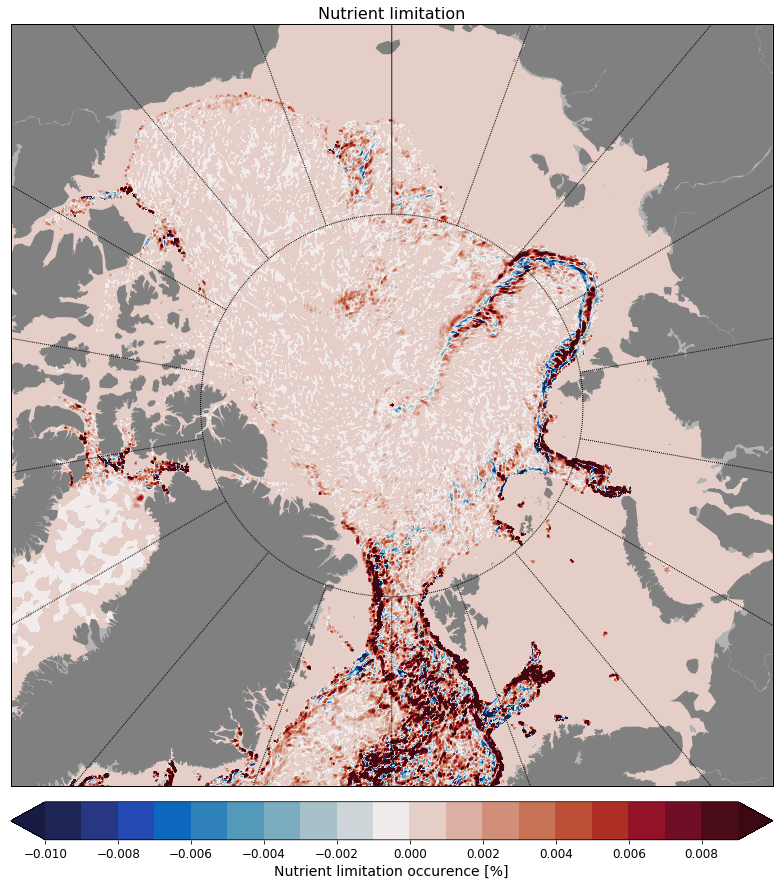

In [11]:
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')

#MLD_sept_mean[MLD_sept_mean == 0] = np.nan
data, elem_no_nan = pf.get_data(np.sum(UVDN,axis=0)*30,mesh,0)
ax1      = fig.add_subplot(111)
contours = np.arange(-.01, .01, .001)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'Nutrient limitation occurence [%]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.title('Nutrient limitation', fontsize=16)